In [1]:
# ------------------ BLOQUE: INICIAR SERVIDOR RAPHTORY Y ACCEDER AL GRAFO ------------------
from raphtory.graphql import GraphServer
import time

# Lanza el servidor GraphQL en la carpeta donde guardaste el grafo
server = GraphServer(work_dir="graphs/").start()
client = server.get_client()



print("🚀 Servidor GraphQL de Raphtory en marcha.")
print("Accede desde tu navegador a: http://localhost:1736")

# El nombre/path de tu grafo es: kiali_fullnode_graph-3
# En la UI GraphQL puedes hacer queries, explorar nodos, aristas y ver todas las propiedades cargadas.


🚀 Servidor GraphQL de Raphtory en marcha.
Accede desde tu navegador a: http://localhost:1736


In [14]:
# Para unir comunicacion y creación


import pandas as pd
from raphtory import Graph
import os
import shutil

# Cargar dataset
csv_path = "./results/final2_modified_sorted.csv"
df = pd.read_csv(csv_path, parse_dates=["timestamp"])

# Crear grafo
g = Graph()

# Nombre del grafo y ruta
graph_name = "microservices_creation_graph"
output_path = f"graphs/{graph_name}"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs", exist_ok=True)

# Obtener el primer timestamp en que aparece cada microservicio
first_appearances = df.sort_values("timestamp").groupby("Microservice").first().reset_index()

# Crear nodos con marca temporal y conexión al pod
for _, row in first_appearances.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    ms = row["Microservice"]
    pod = row["pod"]
    abnormal_class = row["Abnormality class"]

    label = "anomalous" if abnormal_class != 1 else "normal"
    color = "red" if label == "anomalous" else "green"

    g.add_node(ts, ms, node_type="Microservice", properties={
        "label": label,
        "ui_color": color
    })

    g.add_node(ts, pod, node_type="Pod")

    g.add_edge(ts, ms, pod, properties={
        "relationship": "deployed_to",
        "label": "connects"
    })

# Guardar grafo
g.save_to_file(output_path)
print("\u2705 Grafo de creación de microservicios guardado en:", output_path)


✅ Grafo de creación de microservicios guardado en: graphs/microservices_creation_graph


In [15]:
 # ------------------ BLOQUE: VER COLUMNAS ------------------
import pandas as pd

# Cargar el CSV
df = pd.read_csv('./results/kiali_kpi_metrics_processed.csv')
print(df.columns)

Index(['source_workload', 'destination_workload', 'timestamp', 'total_request',
       'new_request', 'success_count', 'error_count', 'success_rate',
       'error_rate', 'average_latency', 'istio_request_bytes', 'throughput',
       'request_rate', 'time_window', 'link_color', 'Abnormality class'],
      dtype='object')


In [16]:
!pip install pyvis


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\marti\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
from raphtory import Graph
import os
import shutil

# Cargar CSV principal
df = pd.read_csv('./results/kiali_kpi_metrics_processed.csv', parse_dates=["timestamp"])

# Crear grafo
g = Graph()

# Nombre del grafo y ruta
graph_name = "microservices_graph_enriched"
output_path = f"graphs/{graph_name}"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs", exist_ok=True)

# Crear nodos y aristas con propiedades temporales
for _, row in df.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    src = row["source_workload"]
    dst = row["destination_workload"]
    abnormal_class = row["Abnormality class"]

    # Etiqueta y color del nodo
    label = "normal" if abnormal_class == 1 else "anomalous"
    color = "green" if abnormal_class == 1 else "red"

    # Propiedades comunes de nodos
    common_props = {
        "success_rate": row["success_rate"],
        "error_rate": row["error_rate"],
        "request_rate": row["request_rate"],
        "throughput": row["throughput"],
        "success_count": row["success_count"],
        "error_count": row["error_count"],
        "Abnormality_class": abnormal_class,
        "time_window": row["time_window"]
    }

    # Añadir nodos
    g.add_node(ts, src, properties=common_props, node_type="Microservice")
    g.add_node(ts, dst, properties=common_props, node_type="Microservice")

    # Etiqueta y color del edge
    edge_label = "normal_link" if abnormal_class == 1 else "anomalous_link"
    edge_color = "green" if abnormal_class == 1 else "red"

    # Arista con props visuales y métricas
    edge_props = {
        "average_latency": row["average_latency"],
        "total_request": row["total_request"],
        "new_request": row["new_request"],
        "istio_request_bytes": row["istio_request_bytes"],
        "Abnormality_class": abnormal_class,
        "link_color": row.get("link_color", edge_color),  # se prioriza la columna si existe
        "relationship": "communicates",
        "label": edge_label,
        "ui_color": edge_color
    }

    g.add_edge(ts, src, dst, properties=edge_props)

# Guardar grafo
g.save_to_file(output_path)
print("✅ Grafo completo con nodos y enlaces etiquetados y coloreados guardado en:", output_path)


✅ Grafo completo con nodos y enlaces etiquetados y coloreados guardado en: graphs/microservices_graph_enriched


In [18]:
import pandas as pd
from raphtory import Graph
import os
import shutil

# Cargar CSV principal
# Usar parse_dates para timestamp
csv_path = './results/kiali_kpi_metrics_processed.csv'
df = pd.read_csv(csv_path, parse_dates=["timestamp"])

# Definir tamaño de la ventana rolling (por ejemplo, 5 minutos)
window_size = '15s'

# Ordenar por timestamp para rolling correcto
df = df.sort_values('timestamp')

# Calcular rolling para cada par (source, destination)
group_cols = ['source_workload', 'destination_workload']
metrics = ['average_latency', 'success_rate', 'error_rate', 'request_rate', 'throughput', 'success_count', 'error_count', 'total_request', 'new_request', 'istio_request_bytes']

# Aplicar rolling por grupo usando DataFrame.rolling (no Series.rolling)
def rolling_group(df_group):
    df_group = df_group.sort_values('timestamp')
    rolled = df_group.set_index('timestamp').rolling(window=window_size, min_periods=1)
    for metric in metrics:
        df_group[f'{metric}_rolling'] = rolled[metric].mean().values
    return df_group.reset_index(drop=True)

df_rolled = df.groupby(group_cols, group_keys=False).apply(rolling_group)

# Crear grafo
rolling_graph = Graph()

# Nombre del grafo y ruta
rolling_graph_name = "microservices_graph_rolling"
rolling_output_path = f"graphs/{rolling_graph_name}"
if os.path.exists(rolling_output_path):
    shutil.rmtree(rolling_output_path)
os.makedirs("graphs", exist_ok=True)

# Añadir nodos y aristas con métricas rolling
for _, row in df_rolled.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    src = row["source_workload"]
    dst = row["destination_workload"]
    abnormal_class = row["Abnormality class"]

    # Etiqueta y color del nodo
    label = "normal" if abnormal_class == 1 else "anomalous"
    color = "green" if abnormal_class == 1 else "red"

    # Propiedades rolling para nodos
    node_props = {
        "success_rate_rolling": row["success_rate_rolling"],
        "error_rate_rolling": row["error_rate_rolling"],
        "request_rate_rolling": row["request_rate_rolling"],
        "throughput_rolling": row["throughput_rolling"],
        "success_count_rolling": row["success_count_rolling"],
        "error_count_rolling": row["error_count_rolling"],
        "Abnormality_class": abnormal_class,
        "time_window": row["time_window"],
        "ui_color": color
    }
    rolling_graph.add_node(ts, src, properties=node_props, node_type="Microservice")
    rolling_graph.add_node(ts, dst, properties=node_props, node_type="Microservice")

    # Propiedades rolling para aristas
    edge_label = "normal_link" if abnormal_class == 1 else "anomalous_link"
    edge_color = "green" if abnormal_class == 1 else "red"
    edge_props = {
        "average_latency_rolling": row["average_latency_rolling"],
        "total_request_rolling": row["total_request_rolling"],
        "new_request_rolling": row["new_request_rolling"],
        "istio_request_bytes_rolling": row["istio_request_bytes_rolling"],
        "Abnormality_class": abnormal_class,
        "link_color": row.get("link_color", edge_color),
        "relationship": "communicates",
        "label": edge_label,
        "ui_color": edge_color
    }
    rolling_graph.add_edge(ts, src, dst, properties=edge_props)

# Guardar grafo rolling
rolling_graph.save_to_file(rolling_output_path)
print(f"✅ Grafo con métricas rolling guardado en: {rolling_output_path}")
# Verifica cómo cambian los valores rolling
print(df_rolled[['timestamp', 'source_workload', 'destination_workload', 'average_latency_rolling']].head(20))
# Verifica la variedad de timestamps
print(df['timestamp'].min(), df['timestamp'].max())
print(df['timestamp'].value_counts().sort_index())

C:\Users\marti\AppData\Local\Temp\ipykernel_30932\940821079.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolled = df.groupby(group_cols, group_keys=False).apply(rolling_group)


✅ Grafo con métricas rolling guardado en: graphs/microservices_graph_rolling
             timestamp  source_workload destination_workload  \
0  2025-04-16 17:30:00  checkoutservice          cartservice   
1  2025-04-16 17:30:00  checkoutservice          cartservice   
2  2025-04-16 17:30:00  checkoutservice          cartservice   
3  2025-04-16 17:30:00  checkoutservice          cartservice   
4  2025-04-16 17:30:00  checkoutservice          cartservice   
5  2025-04-16 17:30:15  checkoutservice          cartservice   
6  2025-04-16 17:30:30  checkoutservice          cartservice   
7  2025-04-16 17:30:30  checkoutservice          cartservice   
8  2025-04-16 17:30:45  checkoutservice          cartservice   
9  2025-04-16 17:31:00  checkoutservice          cartservice   
10 2025-04-16 17:31:00  checkoutservice          cartservice   
11 2025-04-16 17:31:00  checkoutservice          cartservice   
12 2025-04-16 17:31:15  checkoutservice          cartservice   
13 2025-04-16 17:31:30  che

In [19]:
import pandas as pd
from raphtory import Graph
import os
import shutil

# Cargar CSV principal
df = pd.read_csv('./results/kiali_kpi_metrics_processed.csv', parse_dates=["timestamp"])

# Crear grafo
g = Graph()

# Nombre del grafo y ruta
graph_name = "microservices_graph_enriched_temporal"
output_path = f"graphs/{graph_name}"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs", exist_ok=True)

# Crear nodos y aristas con propiedades temporales
added_edges = set()


for _, row in df.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    src = row["source_workload"]
    dst = row["destination_workload"]
    abnormal = row["Abnormality class"]

    common_props = {
        "success_rate": float(row["success_rate"]),
        "error_rate": float(row["error_rate"]),
        "request_rate": float(row["request_rate"]),
        "throughput": float(row["throughput"]),
        "success_count": int(row["success_count"]),
        "error_count": int(row["error_count"]),
        "Abnormality_class": abnormal,
        "ui_color": "green" if abnormal == 1 else "red"
    }

    # 1) Nodo SRC: creación + actualización
    g.add_node(ts, src, properties=common_props, node_type="Microservice")
    g.node(src).add_updates(ts, common_props)

    # 2) Nodo DST: creación + actualización
    g.add_node(ts, dst, properties=common_props, node_type="Microservice")
    g.node(dst).add_updates(ts, common_props)

    # 3) Arista (solo crea la primera vez)
    if (src, dst) not in added_edges:
        label = "normal_link" if abnormal == 1 else "anomalous_link"
        color = "green" if abnormal == 1 else "red"
        g.add_edge(ts, src, dst, properties={
            "relationship": "communicates",
            "label": label,
            "ui_color": color
        })
        added_edges.add((src, dst))

    # 4) Actualizaciones temporales de la arista
    g.edge(src, dst).add_updates(ts, {
        "average_latency": float(row["average_latency"]),
        "total_request": int(row["total_request"]),
        "new_request": int(row["new_request"]),
        "istio_request_bytes": int(row["istio_request_bytes"]),
        "Abnormality_class": abnormal,
        "link_color": row.get("link_color", color)
    })

# Guardar grafo
g.save_to_file(output_path)
print("\u2705 Grafo completo con nodos y enlaces etiquetados y coloreados guardado en:", output_path)


✅ Grafo completo con nodos y enlaces etiquetados y coloreados guardado en: graphs/microservices_graph_enriched_temporal


In [20]:
from raphtory import Graph
from datetime import datetime

# Cargar el grafo desde archivo
g = Graph.load_from_file("graphs/microservices_graph_enriched_temporal")

# Nodo a consultar
node_name = "checkoutservice"
node = g.node(node_name)

print(f"[TOTAL] {node_name} conectó con {node.degree()} nodos.")

# Consulta temporal: antes de cierto instante
cutoff = datetime.strptime("2025-04-16 17:33:00", "%Y-%m-%d %H:%M:%S")
node_before = g.before(cutoff).node(node_name)
print(f"[ANTES de {cutoff}] conectó con {node_before.degree()} nodos.")

# Consulta temporal: entre dos tiempos específicos
start = datetime.strptime("2025-04-16 17:31:00", "%Y-%m-%d %H:%M:%S")
end = datetime.strptime("2025-04-16 17:34:00", "%Y-%m-%d %H:%M:%S")
node_window = g.node(node_name).window(start, end)
print(f"[VENTANA entre {start} y {end}] conectó con {node_window.degree()} nodos.")

# Evolución temporal de latencia entre frontend y checkoutservice
graph_edge = g.edge("frontend", "checkoutservice")
print("\nEvolución de latencia entre 'frontend' y 'checkoutservice':")

for update in graph_edge.history():
    time = datetime.fromtimestamp(update / 1000)  # Convert milliseconds to seconds and then to datetime
    latency = graph_edge.properties["average_latency"] if "average_latency" in graph_edge.properties else "N/A"
    print(f"{time}: {latency} ms")


[TOTAL] checkoutservice conectó con 7 nodos.
[ANTES de 2025-04-16 17:33:00] conectó con 7 nodos.
[VENTANA entre 2025-04-16 17:31:00 y 2025-04-16 17:34:00] conectó con 7 nodos.

Evolución de latencia entre 'frontend' y 'checkoutservice':
2025-04-16 19:30:00: 859.2533913699232 ms
2025-04-16 19:30:00: 859.2533913699232 ms
2025-04-16 19:30:00: 859.2533913699232 ms
2025-04-16 19:30:00: 859.2533913699232 ms
2025-04-16 19:30:00: 859.2533913699232 ms
2025-04-16 19:30:00: 859.2533913699232 ms
2025-04-16 19:30:15: 859.2533913699232 ms
2025-04-16 19:30:30: 859.2533913699232 ms
2025-04-16 19:30:30: 859.2533913699232 ms
2025-04-16 19:30:45: 859.2533913699232 ms
2025-04-16 19:31:00: 859.2533913699232 ms
2025-04-16 19:31:00: 859.2533913699232 ms
2025-04-16 19:31:00: 859.2533913699232 ms
2025-04-16 19:31:15: 859.2533913699232 ms
2025-04-16 19:31:30: 859.2533913699232 ms
2025-04-16 19:31:30: 859.2533913699232 ms
2025-04-16 19:31:45: 859.2533913699232 ms
2025-04-16 19:32:00: 859.2533913699232 ms
2025-04

In [21]:
!pip install raphtory[visualisation]


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\marti\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [22]:
!pip install "raphtory[all]" --upgrade


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\marti\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [23]:
from pyvis.network import Network
import pandas as pd

# Cargar CSV
df = pd.read_csv('./results/kiali_kpi_metrics_processed.csv')
# Diagnóstico rápido del DataFrame
print("¿DataFrame vacío?:", df.empty)
print("Columnas:", df.columns.tolist())
print("Primeras filas:")
print(df.head())
print("Valores únicos en 'Abnormality class':", df["Abnormality class"].unique())

# Crear red visual
net = Network(height="750px", width="100%", directed=True, notebook=False, cdn_resources="in_line")
net.barnes_hut()  # Mejora la dispersión

# Usar sets para evitar duplicados
added_nodes = set()

for _, row in df.iterrows():
    src = row["source_workload"]
    dst = row["destination_workload"]
    # Convert 'Abnormality class' to an integer or map string values to integers
    abnormal_mapping = {"Normal": 1, "Anomalous": 2}  # Example mapping
    abnormal = abnormal_mapping.get(row["Abnormality class"], 0)  # Default to 0 if not found
    color = "green" if abnormal == 1 else "red"

    # Añadir nodos solo si no han sido agregados
    if src not in added_nodes:
        net.add_node(src, label=src, color=color, shape="dot", title=f"Abnormality class: {abnormal}")
        added_nodes.add(src)
    if dst not in added_nodes:
        net.add_node(dst, label=dst, color=color, shape="dot", title=f"Abnormality class: {abnormal}")
        added_nodes.add(dst)

    # Añadir arista con información
    net.add_edge(
        src, dst,
        label="⚠️" if abnormal > 1 else "✔️",
        title=f"Latency: {row['average_latency']}, Requests: {row['total_request']}",
        color=color
    )

# Exportar grafo con encoding explícito
with open("grafo_microservicios.html", "w", encoding="utf-8") as f:
    f.write(net.generate_html())


#para un unico enlace por relación
# # Calcular porcentaje de peticiones normales por cada par (src, dst)
# grouped = df.groupby(['source_workload', 'destination_workload'])['Abnormality class']
# percent_normal = grouped.apply(lambda x: (x == 'Normal').mean() * 100).to_dict()

# # Usar sets para evitar duplicados
# added_nodes = set()
# added_edges = set()  # Añade esto antes del bucle


# for _, row in df.iterrows():
#     src = row["source_workload"]
#     dst = row["destination_workload"]
#     # Convert 'Abnormality class' to an integer or map string values to integers
#     abnormal_mapping = {"Normal": 1, "Anomalous": 2}  # Example mapping
#     abnormal = abnormal_mapping.get(row["Abnormality class"], 0)  # Default to 0 if not found
#     color = "green" if abnormal == 1 else "red"

#     # Añadir nodos solo si no han sido agregados
#     if src not in added_nodes:
#         net.add_node(src, label=src, color=color, shape="dot", title=f"Abnormality class: {abnormal}")
#         added_nodes.add(src)
#     if dst not in added_nodes:
#         net.add_node(dst, label=dst, color=color, shape="dot", title=f"Abnormality class: {abnormal}")
#         added_nodes.add(dst)

#     # Añadir arista con información
#     edge_id = (src, dst)
#     if edge_id not in added_edges:
#         pct = percent_normal.get(edge_id, 0)
#         color = "green" if pct >= 95 else "red"
#         label = f"{pct:.1f}% Normal"
#         net.add_edge(
#             src, dst,
#             label=label,
#             title=f"Porcentaje de normales: {pct:.1f}%",
#             color=color
#         )
#         added_edges.add(edge_id)



print("✅ Grafo generado correctamente. Abre 'grafo_microservicios.html'")


¿DataFrame vacío?: False
Columnas: ['source_workload', 'destination_workload', 'timestamp', 'total_request', 'new_request', 'success_count', 'error_count', 'success_rate', 'error_rate', 'average_latency', 'istio_request_bytes', 'throughput', 'request_rate', 'time_window', 'link_color', 'Abnormality class']
Primeras filas:
   source_workload destination_workload            timestamp  total_request  \
0  checkoutservice          cartservice  2025-04-16 17:30:00         9385.0   
1  checkoutservice          cartservice  2025-04-16 17:30:15         9447.0   
2  checkoutservice          cartservice  2025-04-16 17:30:30         9491.0   
3  checkoutservice          cartservice  2025-04-16 17:30:45         9555.0   
4  checkoutservice          cartservice  2025-04-16 17:31:00         9625.0   

   new_request  success_count  error_count  success_rate  error_rate  \
0          0.0            0.0          0.0           NaN         NaN   
1         62.0           62.0          0.0           1.0 

# Abre una terminal en la carpeta del archivo
cd /ruta/del/archivo
python -m http.server 8000
http://localhost:8000/grafo_microservicios.html

In [24]:
from pyvis.network import Network

# Crear red visual solo con nodos y enlaces anómalos
net = Network(height="750px", width="100%", directed=True, notebook=False, cdn_resources="in_line")
net.barnes_hut()
anomalous_df = pd.read_csv('./Nodos_An_malos.csv')

# Añadir nodos y aristas únicos
added_nodes = set()
for _, row in anomalous_df.iterrows():
    src = row["source_workload"]
    dst = row["destination_workload"]
    color = "red"
    label = "anomalous"

    if src not in added_nodes:
        net.add_node(src, label=src, color=color, shape="dot", title="Anomalous Node")
        added_nodes.add(src)
    if dst not in added_nodes:
        net.add_node(dst, label=dst, color=color, shape="dot", title="Anomalous Node")
        added_nodes.add(dst)

    net.add_edge(
        src, dst,
        label=label,
        title=f"Latency: {row['average_latency']}, Error rate: {row['error_rate']}",
        color=color
    )

# Guardar como archivo HTML
output_path = "grafo_anomalous_only.html"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(net.generate_html())

output_path



'grafo_anomalous_only.html'

In [25]:
pip install pandas raphtory-client


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement raphtory-client (from versions: none)
ERROR: No matching distribution found for raphtory-client

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Evolución temporal del grado de un nodo en los diferentes grafos
Visualiza cómo cambia el número de conexiones de un microservicio concreto (por ejemplo, "frontend") a lo largo del tiempo en cada uno de los grafos generados: enriched, temporal y rolling.

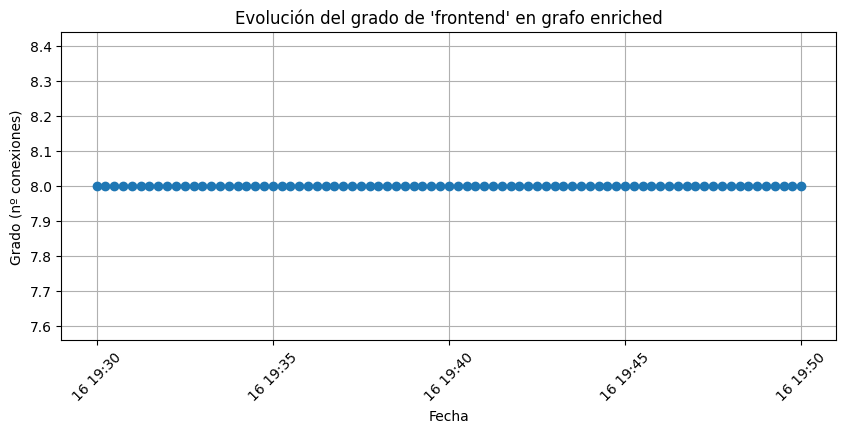

In [26]:
import matplotlib.pyplot as plt
from raphtory import Graph
from datetime import datetime

# Cambia el nombre del nodo si quieres analizar otro microservicio
node_name = "frontend"

# --- Grafo enriched ---
g_enriched = Graph.load_from_file("graphs/microservices_graph_enriched")
times = []
degrees = []
for t in g_enriched.node(node_name).history():
    # Convertimos el timestamp (ms) a datetime
    dt = datetime.fromtimestamp(int(t) / 1000)
    times.append(dt)
    # Consultamos el grado del nodo 'node_name' justo antes o en dt
    degrees.append(g_enriched.before(dt).node(node_name).degree())

plt.figure(figsize=(10,4))
plt.plot(times, degrees, marker="o")
plt.title(f"Evolución del grado de '{node_name}' en grafo enriched")
plt.xlabel("Fecha")
plt.ylabel("Grado (nº conexiones)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

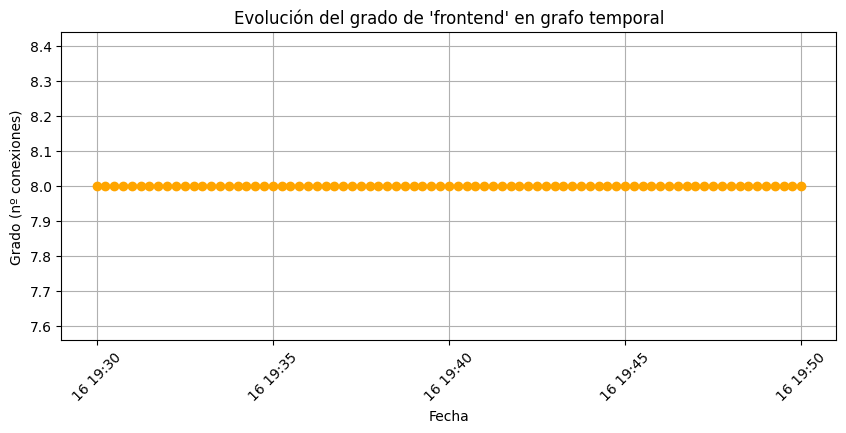

In [27]:
# --- Grafo temporal ---
g_temporal = Graph.load_from_file("graphs/microservices_graph_enriched_temporal")
times = []
degrees = []
for snapshot in g_temporal.node(node_name).history():
    dt = datetime.fromtimestamp(int(snapshot) / 1000)
    times.append(dt)
    degrees.append(g_temporal.before(dt).node(node_name).degree())
plt.figure(figsize=(10,4))
plt.plot(times, degrees, marker="o", color="orange")
plt.title(f"Evolución del grado de '{node_name}' en grafo temporal")
plt.xlabel("Fecha")
plt.ylabel("Grado (nº conexiones)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

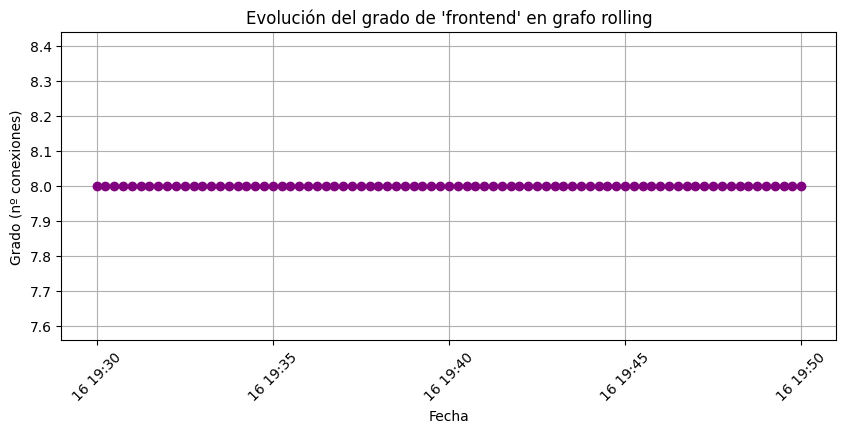

In [29]:
# --- Grafo rolling ---
# rolling_graph, node_name, and plt are already available from previous cells

times = []
degrees = []
for snapshot in rolling_graph.node(node_name).history():
    dt = datetime.fromtimestamp(int(snapshot) / 1000)
    times.append(dt)
    degrees.append(rolling_graph.before(dt).node(node_name).degree())

plt.figure(figsize=(10,4))
plt.plot(times, degrees, marker="o", color="purple")
plt.title(f"Evolución del grado de '{node_name}' en grafo rolling")
plt.xlabel("Fecha")
plt.ylabel("Grado (nº conexiones)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()